In [1]:
import sys
import shutil
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/langevin/langevin/dev/flopy3fork.git/flopy


In [2]:
# Path to the MODFLOW 6 repository
mf6path = '../../../modflow6-fork.git'
assert os.path.isdir(mf6path)

In [3]:
mf6exe = os.path.join(mf6path, 'bin', 'mf6')
mf6exe = os.path.abspath(mf6exe)
assert os.path.isfile(mf6exe)
print(mf6exe)

/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


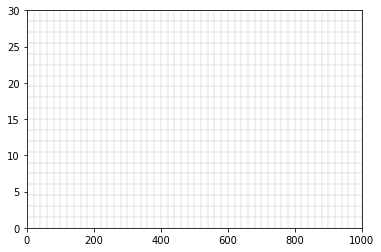

In [4]:
def make_grid(nlay, nrow, ncol, lx, top0):
    top = np.zeros((nrow, ncol), dtype=np.float)
    botm = np.zeros((nlay, nrow, ncol), dtype=np.float)

    delr = lx / ncol
    delc = 1.
    delv = top0 / nlay
    top[:, :] = top0
    
    for k in range(nlay):
        tp = top0
        if k > 0:
            tp = botm[k - 1, 0, 0]
        botm[k, :, :] = tp - delv
    
    delr = np.ones((ncol)) * delr
    delc = np.ones((nrow)) * delc
    return (delr, delc, top, botm)

nlay = 20
nrow = 1
ncol = 50
lx = 1000.
top0 = 30.
delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0)
mg = flopy.discretization.StructuredGrid(nlay=nlay, nrow=nrow, ncol=ncol,
                                         delr=delr, delc=delc, top=top, botm=botm)
pxs = flopy.plot.PlotCrossSection(modelgrid=mg, line={'row': 0})
pxs.plot_grid(alpha=1., lw=0.1)

In [5]:
def calcdens(c, rho0=1000., drhodc=0.7):
    return rho0 + drhodc * c

def get_sealevel(t, sl_start, slr_rate):
    return sl_start + slr_rate * t

def get_top(x, top0, slopels):
    return top0 + x * slopels

In [6]:
def get_model(ws, name, nlay, nrow, ncol, lx,
              top0, sl_start, slr_rate, time_end,
              hydraulic_conductivity, specific_storage, porosity, 
              recharge,
              alpha_l, alpha_t,
              cfresh, csalt,
              nper=100,
              hstrt=None, cstrt=None,
              converge_continue=False,
              constant_concentration=False,
              etrate=0., etsurface=None, etdepth=None, 
              verbosity_level=1):

    delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0)

    nstp = 1
    perlen = nper * [time_end / nper]
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp, 1.0))

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-7, 1e-5, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=mf6exe,
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    if converge_continue:
        sim.name_file.continue_ = True
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name
    
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, newtonoptions=True)
    imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='DBD',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  no_ptcrecord=True,
                                  filename='{}.ims'.format(gwfname))
    single_matrix = False
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    if hstrt is None:
        hstrt = sl_start
    else:
        hstrt = {'filename': 'hstrt.bin', 'factor': 1.0, 
                 'data': hstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwfic(gwf, strt=hstrt)

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  icelltype=1,
                                  k=hydraulic_conductivity)
    
    sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=1, sy=porosity, ss=specific_storage)

    hhformulation = True
    hhoptions = False
    if hhformulation:
        hhoptions = [('HHFORMULATION'), ]
        hhoptions.append(('LHS'))
    buy = flopy.mf6.ModflowGwfbuy(gwf, hhoptions=hhoptions)

    # ghb on left edge
    delt = time_end / nper
    delv = top[0, 0] - botm[0, 0, 0]
    ghbdict = {}
    cond = hydraulic_conductivity * delc * delv / (0.5 * delr[0])
    for iper, t in enumerate(np.arange(delt, time_end + delt, delt)):
        sl = get_sealevel(t, sl_start, slr_rate)
        ghblist = []
        for k in range(nlay):
            if sl > botm[k, 0, 0]:
                tp = top[0, 0]
                if k > 1:
                    tp = botm[k - 1, 0, 0]
                delv = tp - botm[k, 0, 0]
                satdz = min(tp, sl) - botm[k, 0, 0]
                cond = hydraulic_conductivity * delc[0] * satdz / (0.5 * delr[0])
                elev = botm[k, 0, 0] + 0.5 * satdz
                ghblist.append([(k, 0, 0), sl, cond, csalt, calcdens(csalt), elev])
        if len(ghblist) > 0:
            ghbdict[iper] = ghblist
    if len(ghbdict) > 0:
        ghb = flopy.mf6.ModflowGwfghb(gwf,
                                      stress_period_data=ghbdict,
                                      print_input=True,
                                      print_flows=True,
                                      save_flows=False,
                                      auxiliary=['CONCENTRATION', 'DENSITY', 'ELEVATION'],
                                      pname='GHB-LEFT',
                                      filename='{}.left.ghb'.format(gwfname))
        
    rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    
    if etsurface is None:
        etsurface = top0
    if etdepth is not None:
        evt = flopy.mf6.ModflowGwfevta(gwf, surface=etsurface, rate=etrate, depth=etdepth)
    
    # output control
    saverecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')]}
    printrecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    if not single_matrix:
        imsgwt = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                      outer_hclose=hclose,
                                      outer_maximum=nouter,
                                      under_relaxation='NONE',
                                      inner_maximum=ninner,
                                      inner_hclose=hclose, rcloserecord=rclose,
                                      linear_acceleration='BICGSTAB',
                                      scaling_method='NONE',
                                      reordering_method='NONE',
                                      relaxation_factor=relax,
                                      filename='{}.ims'.format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm)

    # initial conditions
    if cstrt is None:
        cstrt = csalt
    else:
        cstrt = {'filename': 'cstrt.bin', 'factor': 1.0, 
                 'data': cstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwtic(gwt, strt=cstrt)

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM')

    # dispersion
    dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=False, diffc=0.,
                                  alh=alpha_l, ath1=alpha_t)

    # mass storage and transfer
    porosity = porosity
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)

    # sources
    sourcerecarray = [('GHB-LEFT', 'AUX', 'CONCENTRATION'),
                     ]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                                  filename='{}.ssm'.format(gwtname))
    
    # constant concentration
    if constant_concentration:
        cnclist = []
        for k in range(1, nlay):
            cnclist.append([(k, 0, 0), 35.])
        cnc1 = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cnclist)
        
        if len(cncdict) > 0:
            cnc2 = flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cncdict,
                                           pname='CNC-2',
                                           filename='{}2.cnc'.format(gwtname))

    # output control
    saverecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: [('CONCENTRATION', 'ALL')],
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    printrecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    return sim

In [7]:
def get_results(ws, sim):
    modelnames = list(sim.model_names)
    gwfname = modelnames[0]
    gwtname = modelnames[1]
    gwf = sim.get_model(gwfname)
    gwt = sim.get_model(gwtname)

    fname = os.path.join(ws, gwfname + '.hds')
    hdobj = flopy.utils.HeadFile(fname, precision='double')
    head = hdobj.get_alldata()

    fname = os.path.join(ws, gwtname + '.ucn')
    cnobj = flopy.utils.HeadFile(fname, precision='double', text='CONCENTRATION')
    conc = cnobj.get_alldata()
    times = cnobj.get_times()
    
    fname = os.path.join(ws, gwfname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname, precision='double')
    spdis = budobj.get_data(text='DATA-SPDIS')
    
    return head, conc, spdis, times

In [8]:
def lens_analytical(x, t, length, porosity, hydraulic_conductivity, recharge, rhof, rhos):
    alpha = rhof / (rhos - rhof)
    pl = np.sqrt(recharge / hydraulic_conductivity / (1 + alpha))
    taul = np.pi * porosity * length / 4. * np.sqrt((1 + alpha) / hydraulic_conductivity / recharge)
    fl = np.tanh(t / taul)
    h = fl * pl * np.sqrt(np.square(length) - np.square(x))
    d = alpha * h
    return x, np.flipud(h), np.flipud(d)

In [9]:
def lens_volume(gwf, head, conc, csalt=35.):
    nlay, nrow, ncol = head.shape
    top = gwf.dis.top.array
    botm = gwf.dis.botm.array
    delr = gwf.dis.delr.array
    delc = gwf.dis.delc.array
    fresh_volume = 0.
    for k in range(nlay):
        for i in range(nrow):
            for j in range(ncol):
                tp = top[i, j]
                if k > 0:
                    tp = botm[k - 1, i, j]
                hd = max(head[k, i, j], botm[k, i, j])
                sat_thick = min(tp, hd) - botm[k, i, j]
                sat_vol = sat_thick * delr[j] * delc[i]
                fvol = sat_vol * (1. - conc[k, i, j] / csalt)
                fresh_volume += fvol
    return fresh_volume

def lens_volume_timeseries(gwf, head, conc, times):
    nper = conc.shape[0]
    results = np.empty((nper, 2))
    kperlist = range(0, nper)
    for i, kper in enumerate(kperlist):
        results[kper, 0] = times[kper]
        results[kper, 1] = lens_volume(gwf, head[kper], conc[kper])
    return results

In [10]:
def get_colored_patch_collection(modelgrid, head=None, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            x0 = xv[0, j]
            x1 = xv[0, j + 1]
            y0 = zv[k, 0, j]
            y1 = zv[k + 1, 0, j]
            if head is not None:
                y0 = min(y0, head[k, 0, j])
                y0 = max(y0, modelgrid.botm[k, 0, j])
            poly = [[x0, y0], [x1, y0], [x1, y1], [x0, y1], [x0, y0]]
            #print(poly)
            patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
            patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True, cmap='jet')
    return pc

In [109]:
def make_figure(gwf, head, conc, spdis, sl, t, top0, csalt=35., 
                ax2dict=None, asoln=None, streamplot=False, vectors=False,
                figname=None):

    plt.rcParams['savefig.facecolor'] = '1.0'
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    ax.set_aspect('auto')
    
    pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
    pxs.plot_grid(alpha=1., lw=0.1)

    # draw a patch collection, with the water table as the top of the cell
    pc = get_colored_patch_collection(gwf.modelgrid, head, ec='none', fc='none', zorder=2)
    pc.set_array(conc.flatten())
    ax.add_collection(pc)

    cbar = plt.colorbar(pc, shrink=0.5)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('CONCENTRATION, IN GRAMS PER LITER', rotation=90)
    
    # analytical solution, if specified
    if asoln is not None:
        x, h, z = asoln
        ax.plot(x, sl - z, 'w--')

    # 50% seawater line
    atoplot = np.ma.masked_where(head < gwf.dis.botm.array, conc)
    pxs.contour_array(atoplot, levels=np.array([.5])* csalt, 
                      linestyles = ['-'], colors=['k'])

    if vectors:
        pxs.plot_specific_discharge(spdis, head=head, color='white',
                                    kstep=1, hstep=1, pivot='mid', minlength=0.5,
                                    scale=0.1, width=0.001, headwidth=3., headlength=5.0, 
                                    headaxislength=4.5, minshaft=0.01,
                                    zorder=10, alpha=0.50)
    
    if streamplot:
        x = gwf.modelgrid.xcellcenters
        y = gwf.modelgrid.zcellcenters
        X, Y = np.meshgrid(x, y[:, 0, 0])
        u = spdis['qx']
        u = u.reshape(X.shape)
        v = spdis['qz']
        v = v.reshape(X.shape)
        sc = ax.streamplot(X, Y, u, v, color='yellow', linewidth=0.1, arrowsize=0.35)

    #xsl = (sl - top0) / slopels
    #sea_poly = [[0, sl], [xsl, sl], [0, top0], [0, sl]]
    #sea_patch = matplotlib.patches.Polygon(sea_poly, closed=True, edgecolor='k', facecolor='red')
    #ax.add_patch(sea_patch)        

    # head surface
    #ax.plot(gwf.modelgrid.xcellcenters[0], head[kper, 0, 0, :])
    #plt.colorbar(qm, shrink=0.5)
    ax.set_title('TIME = {:.2f} years'.format(t / 365.))
    ax.set_xlabel('DISTANCE, IN METERS')
    ax.set_ylabel('ELEVATION, IN METERS')
    
    plt.tight_layout()
    
    if ax2dict is not None:
        with plt.rc_context({'axes.edgecolor':'white', 
                             'axes.facecolor':'yellow',
                             'xtick.color':'white', 
                             'ytick.color':'white', 
                             'font.size': 8,
                             'axes.labelcolor': 'white',
                             }):
            if 'limits' in ax2dict:
                limits = ax2dict['limits']
            else:
                limits = [0.15, 0.22, 0.2, 0.2]
            xdata = ax2dict['xdata']
            ydata = ax2dict['ydata']
            ax2 = fig.add_axes(limits)
            ax2.plot(xdata, ydata, 'k-')
            if 'xlim' in ax2dict:
                ax2.set_xlim(*ax2dict['xlim'])
            if 'ylim' in ax2dict:
                ax2.set_ylim(*ax2dict['ylim'])
            if 'xlabel' in ax2dict:
                ax2.set_xlabel(ax2dict['xlabel'])
            if 'ylabel' in ax2dict:
                ax2.set_ylabel(ax2dict['ylabel'])
    
    if figname is not None:
        plt.savefig(figname, dpi=300)
        plt.close(fig)
        
    return ax

In [12]:
def make_movie(figfile, anmfile):
    from subprocess import check_output
    vcodec = 'libx264'
    if os.path.isfile(anmfile):
        os.remove(anmfile)
    output = check_output(['ffmpeg',
                           '-f', 'image2',
                           '-i', figfile,
                           '-vb', '20M',
                           '-vcodec', vcodec,
                           '-pix_fmt', 'yuv420p',
                           anmfile])    

In [13]:
# Protection
sim = None
sim0 = None
gwf = None
ws = None
ws0 = None
head = None
head0 = None
conc = None
conc0 = None

# No SLR

In [91]:
gfact = 0.5
nlay = int(85 * gfact)
nrow = 1
ncol = int(100 * gfact)
lx = 1000.
top0 = 85.
nper = 2000
sl_start = 80.
slr_rate = 0.
time_end = 365. * 2000
cfresh = 0.
csalt = 35.
recharge = 18.25 / 1000. / 365. # convert mm/yr to m/yr to m/day
porosity = 0.20
hydraulic_conductivity = 1. # m/day
specific_storage = 0.008 # per meter
alpha_l = 0. # meter
alpha_t = 0.0 # meter

In [92]:
ws0 = 'temp/pxx_gwt_slr-island0'
name = 'slr'
sim0 = get_model(ws0, name, nlay, nrow, ncol, lx,
                 top0, sl_start, slr_rate, time_end, 
                 hydraulic_conductivity, specific_storage, porosity, 
                 recharge,
                 alpha_l, alpha_t,
                 cfresh, csalt,
                 constant_concentration=False,
                 verbosity_level=1, nper=nper)
sim0.write_simulation()
v = sim0.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package slr.gwfgwt...
  writing model gwf_slr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
    writing package ghb-left...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 40 based on size of stress_period_data
    writing package rcha...
    writing package oc...
  writing model gwt_slr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOL

 Solving:  Stress period:   128    Time step:     1
 Solving:  Stress period:   129    Time step:     1
 Solving:  Stress period:   130    Time step:     1
 Solving:  Stress period:   131    Time step:     1
 Solving:  Stress period:   132    Time step:     1
 Solving:  Stress period:   133    Time step:     1
 Solving:  Stress period:   134    Time step:     1
 Solving:  Stress period:   135    Time step:     1
 Solving:  Stress period:   136    Time step:     1
 Solving:  Stress period:   137    Time step:     1
 Solving:  Stress period:   138    Time step:     1
 Solving:  Stress period:   139    Time step:     1
 Solving:  Stress period:   140    Time step:     1
 Solving:  Stress period:   141    Time step:     1
 Solving:  Stress period:   142    Time step:     1
 Solving:  Stress period:   143    Time step:     1
 Solving:  Stress period:   144    Time step:     1
 Solving:  Stress period:   145    Time step:     1
 Solving:  Stress period:   146    Time step:     1
 Solving:  S

 Solving:  Stress period:   299    Time step:     1
 Solving:  Stress period:   300    Time step:     1
 Solving:  Stress period:   301    Time step:     1
 Solving:  Stress period:   302    Time step:     1
 Solving:  Stress period:   303    Time step:     1
 Solving:  Stress period:   304    Time step:     1
 Solving:  Stress period:   305    Time step:     1
 Solving:  Stress period:   306    Time step:     1
 Solving:  Stress period:   307    Time step:     1
 Solving:  Stress period:   308    Time step:     1
 Solving:  Stress period:   309    Time step:     1
 Solving:  Stress period:   310    Time step:     1
 Solving:  Stress period:   311    Time step:     1
 Solving:  Stress period:   312    Time step:     1
 Solving:  Stress period:   313    Time step:     1
 Solving:  Stress period:   314    Time step:     1
 Solving:  Stress period:   315    Time step:     1
 Solving:  Stress period:   316    Time step:     1
 Solving:  Stress period:   317    Time step:     1
 Solving:  S

 Solving:  Stress period:   463    Time step:     1
 Solving:  Stress period:   464    Time step:     1
 Solving:  Stress period:   465    Time step:     1
 Solving:  Stress period:   466    Time step:     1
 Solving:  Stress period:   467    Time step:     1
 Solving:  Stress period:   468    Time step:     1
 Solving:  Stress period:   469    Time step:     1
 Solving:  Stress period:   470    Time step:     1
 Solving:  Stress period:   471    Time step:     1
 Solving:  Stress period:   472    Time step:     1
 Solving:  Stress period:   473    Time step:     1
 Solving:  Stress period:   474    Time step:     1
 Solving:  Stress period:   475    Time step:     1
 Solving:  Stress period:   476    Time step:     1
 Solving:  Stress period:   477    Time step:     1
 Solving:  Stress period:   478    Time step:     1
 Solving:  Stress period:   479    Time step:     1
 Solving:  Stress period:   480    Time step:     1
 Solving:  Stress period:   481    Time step:     1
 Solving:  S

 Solving:  Stress period:   628    Time step:     1
 Solving:  Stress period:   629    Time step:     1
 Solving:  Stress period:   630    Time step:     1
 Solving:  Stress period:   631    Time step:     1
 Solving:  Stress period:   632    Time step:     1
 Solving:  Stress period:   633    Time step:     1
 Solving:  Stress period:   634    Time step:     1
 Solving:  Stress period:   635    Time step:     1
 Solving:  Stress period:   636    Time step:     1
 Solving:  Stress period:   637    Time step:     1
 Solving:  Stress period:   638    Time step:     1
 Solving:  Stress period:   639    Time step:     1
 Solving:  Stress period:   640    Time step:     1
 Solving:  Stress period:   641    Time step:     1
 Solving:  Stress period:   642    Time step:     1
 Solving:  Stress period:   643    Time step:     1
 Solving:  Stress period:   644    Time step:     1
 Solving:  Stress period:   645    Time step:     1
 Solving:  Stress period:   646    Time step:     1
 Solving:  S

 Solving:  Stress period:   789    Time step:     1
 Solving:  Stress period:   790    Time step:     1
 Solving:  Stress period:   791    Time step:     1
 Solving:  Stress period:   792    Time step:     1
 Solving:  Stress period:   793    Time step:     1
 Solving:  Stress period:   794    Time step:     1
 Solving:  Stress period:   795    Time step:     1
 Solving:  Stress period:   796    Time step:     1
 Solving:  Stress period:   797    Time step:     1
 Solving:  Stress period:   798    Time step:     1
 Solving:  Stress period:   799    Time step:     1
 Solving:  Stress period:   800    Time step:     1
 Solving:  Stress period:   801    Time step:     1
 Solving:  Stress period:   802    Time step:     1
 Solving:  Stress period:   803    Time step:     1
 Solving:  Stress period:   804    Time step:     1
 Solving:  Stress period:   805    Time step:     1
 Solving:  Stress period:   806    Time step:     1
 Solving:  Stress period:   807    Time step:     1
 Solving:  S

 Solving:  Stress period:   959    Time step:     1
 Solving:  Stress period:   960    Time step:     1
 Solving:  Stress period:   961    Time step:     1
 Solving:  Stress period:   962    Time step:     1
 Solving:  Stress period:   963    Time step:     1
 Solving:  Stress period:   964    Time step:     1
 Solving:  Stress period:   965    Time step:     1
 Solving:  Stress period:   966    Time step:     1
 Solving:  Stress period:   967    Time step:     1
 Solving:  Stress period:   968    Time step:     1
 Solving:  Stress period:   969    Time step:     1
 Solving:  Stress period:   970    Time step:     1
 Solving:  Stress period:   971    Time step:     1
 Solving:  Stress period:   972    Time step:     1
 Solving:  Stress period:   973    Time step:     1
 Solving:  Stress period:   974    Time step:     1
 Solving:  Stress period:   975    Time step:     1
 Solving:  Stress period:   976    Time step:     1
 Solving:  Stress period:   977    Time step:     1
 Solving:  S

 Solving:  Stress period:  1133    Time step:     1
 Solving:  Stress period:  1134    Time step:     1
 Solving:  Stress period:  1135    Time step:     1
 Solving:  Stress period:  1136    Time step:     1
 Solving:  Stress period:  1137    Time step:     1
 Solving:  Stress period:  1138    Time step:     1
 Solving:  Stress period:  1139    Time step:     1
 Solving:  Stress period:  1140    Time step:     1
 Solving:  Stress period:  1141    Time step:     1
 Solving:  Stress period:  1142    Time step:     1
 Solving:  Stress period:  1143    Time step:     1
 Solving:  Stress period:  1144    Time step:     1
 Solving:  Stress period:  1145    Time step:     1
 Solving:  Stress period:  1146    Time step:     1
 Solving:  Stress period:  1147    Time step:     1
 Solving:  Stress period:  1148    Time step:     1
 Solving:  Stress period:  1149    Time step:     1
 Solving:  Stress period:  1150    Time step:     1
 Solving:  Stress period:  1151    Time step:     1
 Solving:  S

 Solving:  Stress period:  1291    Time step:     1
 Solving:  Stress period:  1292    Time step:     1
 Solving:  Stress period:  1293    Time step:     1
 Solving:  Stress period:  1294    Time step:     1
 Solving:  Stress period:  1295    Time step:     1
 Solving:  Stress period:  1296    Time step:     1
 Solving:  Stress period:  1297    Time step:     1
 Solving:  Stress period:  1298    Time step:     1
 Solving:  Stress period:  1299    Time step:     1
 Solving:  Stress period:  1300    Time step:     1
 Solving:  Stress period:  1301    Time step:     1
 Solving:  Stress period:  1302    Time step:     1
 Solving:  Stress period:  1303    Time step:     1
 Solving:  Stress period:  1304    Time step:     1
 Solving:  Stress period:  1305    Time step:     1
 Solving:  Stress period:  1306    Time step:     1
 Solving:  Stress period:  1307    Time step:     1
 Solving:  Stress period:  1308    Time step:     1
 Solving:  Stress period:  1309    Time step:     1
 Solving:  S

 Solving:  Stress period:  1451    Time step:     1
 Solving:  Stress period:  1452    Time step:     1
 Solving:  Stress period:  1453    Time step:     1
 Solving:  Stress period:  1454    Time step:     1
 Solving:  Stress period:  1455    Time step:     1
 Solving:  Stress period:  1456    Time step:     1
 Solving:  Stress period:  1457    Time step:     1
 Solving:  Stress period:  1458    Time step:     1
 Solving:  Stress period:  1459    Time step:     1
 Solving:  Stress period:  1460    Time step:     1
 Solving:  Stress period:  1461    Time step:     1
 Solving:  Stress period:  1462    Time step:     1
 Solving:  Stress period:  1463    Time step:     1
 Solving:  Stress period:  1464    Time step:     1
 Solving:  Stress period:  1465    Time step:     1
 Solving:  Stress period:  1466    Time step:     1
 Solving:  Stress period:  1467    Time step:     1
 Solving:  Stress period:  1468    Time step:     1
 Solving:  Stress period:  1469    Time step:     1
 Solving:  S

 Solving:  Stress period:  1616    Time step:     1
 Solving:  Stress period:  1617    Time step:     1
 Solving:  Stress period:  1618    Time step:     1
 Solving:  Stress period:  1619    Time step:     1
 Solving:  Stress period:  1620    Time step:     1
 Solving:  Stress period:  1621    Time step:     1
 Solving:  Stress period:  1622    Time step:     1
 Solving:  Stress period:  1623    Time step:     1
 Solving:  Stress period:  1624    Time step:     1
 Solving:  Stress period:  1625    Time step:     1
 Solving:  Stress period:  1626    Time step:     1
 Solving:  Stress period:  1627    Time step:     1
 Solving:  Stress period:  1628    Time step:     1
 Solving:  Stress period:  1629    Time step:     1
 Solving:  Stress period:  1630    Time step:     1
 Solving:  Stress period:  1631    Time step:     1
 Solving:  Stress period:  1632    Time step:     1
 Solving:  Stress period:  1633    Time step:     1
 Solving:  Stress period:  1634    Time step:     1
 Solving:  S

 Solving:  Stress period:  1783    Time step:     1
 Solving:  Stress period:  1784    Time step:     1
 Solving:  Stress period:  1785    Time step:     1
 Solving:  Stress period:  1786    Time step:     1
 Solving:  Stress period:  1787    Time step:     1
 Solving:  Stress period:  1788    Time step:     1
 Solving:  Stress period:  1789    Time step:     1
 Solving:  Stress period:  1790    Time step:     1
 Solving:  Stress period:  1791    Time step:     1
 Solving:  Stress period:  1792    Time step:     1
 Solving:  Stress period:  1793    Time step:     1
 Solving:  Stress period:  1794    Time step:     1
 Solving:  Stress period:  1795    Time step:     1
 Solving:  Stress period:  1796    Time step:     1
 Solving:  Stress period:  1797    Time step:     1
 Solving:  Stress period:  1798    Time step:     1
 Solving:  Stress period:  1799    Time step:     1
 Solving:  Stress period:  1800    Time step:     1
 Solving:  Stress period:  1801    Time step:     1
 Solving:  S

 Solving:  Stress period:  1943    Time step:     1
 Solving:  Stress period:  1944    Time step:     1
 Solving:  Stress period:  1945    Time step:     1
 Solving:  Stress period:  1946    Time step:     1
 Solving:  Stress period:  1947    Time step:     1
 Solving:  Stress period:  1948    Time step:     1
 Solving:  Stress period:  1949    Time step:     1
 Solving:  Stress period:  1950    Time step:     1
 Solving:  Stress period:  1951    Time step:     1
 Solving:  Stress period:  1952    Time step:     1
 Solving:  Stress period:  1953    Time step:     1
 Solving:  Stress period:  1954    Time step:     1
 Solving:  Stress period:  1955    Time step:     1
 Solving:  Stress period:  1956    Time step:     1
 Solving:  Stress period:  1957    Time step:     1
 Solving:  Stress period:  1958    Time step:     1
 Solving:  Stress period:  1959    Time step:     1
 Solving:  Stress period:  1960    Time step:     1
 Solving:  Stress period:  1961    Time step:     1
 Solving:  S

In [93]:
# load results
head0, conc0, spdis0, times0 = get_results(ws0, sim0)
gwf = sim0.get_model('gwf_slr')
lensvolts0 = lens_volume_timeseries(gwf, head0, conc0, times0)

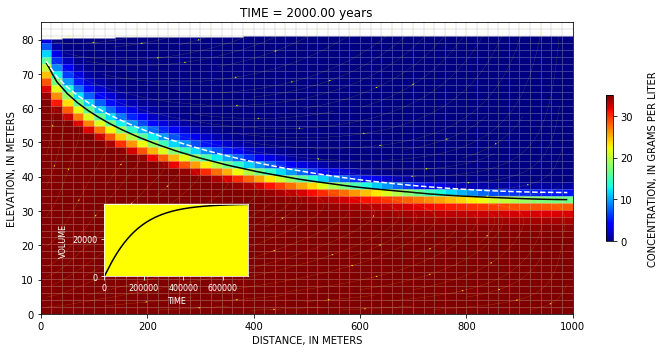

In [111]:
kper = -1
sl = get_sealevel(times0[kper], sl_start, slr_rate)
asoln = lens_analytical(gwf.modelgrid.xcellcenters[0], times0[kper], lx, porosity, 
                        hydraulic_conductivity, recharge, 1000, 1024.5)
ax = make_figure(gwf, head0[kper], conc0[kper], spdis0[kper], 
            sl, times0[kper], top0, 
            asoln=asoln,
            ax2dict={'xdata': lensvolts0[:kper, 0], 
                     'ydata': lensvolts0[:kper, 1],
                     'xlabel': 'TIME',
                     'ylabel': 'VOLUME',
                     'xlim': (0, lensvolts0[:, 0].max()),
                     'ylim': (0, lensvolts0[:, 1].max())},
            streamplot=True)

In [113]:
make_png = True
if make_png:

    pngdir = os.path.join(ws0, 'png')
    if os.path.isdir(pngdir):
        shutil.rmtree(pngdir)
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    kperlist = range(0, conc0.shape[0], 10)
    #kperlist = [0]
    for ifig, kper in enumerate(kperlist):
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(pngdir, fname)
        print('writing {}'.format(fname))

        sl = get_sealevel(times0[kper], sl_start, slr_rate)
        asoln = lens_analytical(gwf.modelgrid.xcellcenters[0], times0[kper], lx, porosity, 
                                hydraulic_conductivity, recharge, 1000, 1024.5)
        ax2dict = {'xdata': lensvolts0[:kper, 0], 
                   'ydata': lensvolts0[:kper, 1],
                   'xlabel': 'TIME',
                   'ylabel': 'VOLUME',
                   'xlim': (0, lensvolts0[:, 0].max()),
                   'ylim': (0, lensvolts0[:, 1].max())}
        make_figure(gwf, head0[kper], conc0[kper], spdis0[kper], 
                    sl, times0[kper], top0, asoln=asoln,
                    ax2dict=ax2dict, streamplot=True, figname=fname)
        
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws0, 'movie.mp4')
    make_movie(figfile, anmfile)

writing temp/pxx_gwt_slr-island0/png/img0.png
writing temp/pxx_gwt_slr-island0/png/img1.png
writing temp/pxx_gwt_slr-island0/png/img2.png
writing temp/pxx_gwt_slr-island0/png/img3.png
writing temp/pxx_gwt_slr-island0/png/img4.png
writing temp/pxx_gwt_slr-island0/png/img5.png
writing temp/pxx_gwt_slr-island0/png/img6.png
writing temp/pxx_gwt_slr-island0/png/img7.png
writing temp/pxx_gwt_slr-island0/png/img8.png
writing temp/pxx_gwt_slr-island0/png/img9.png
writing temp/pxx_gwt_slr-island0/png/img10.png
writing temp/pxx_gwt_slr-island0/png/img11.png
writing temp/pxx_gwt_slr-island0/png/img12.png
writing temp/pxx_gwt_slr-island0/png/img13.png
writing temp/pxx_gwt_slr-island0/png/img14.png
writing temp/pxx_gwt_slr-island0/png/img15.png
writing temp/pxx_gwt_slr-island0/png/img16.png
writing temp/pxx_gwt_slr-island0/png/img17.png
writing temp/pxx_gwt_slr-island0/png/img18.png
writing temp/pxx_gwt_slr-island0/png/img19.png
writing temp/pxx_gwt_slr-island0/png/img20.png
writing temp/pxx_gwt_sl

writing temp/pxx_gwt_slr-island0/png/img173.png
writing temp/pxx_gwt_slr-island0/png/img174.png
writing temp/pxx_gwt_slr-island0/png/img175.png
writing temp/pxx_gwt_slr-island0/png/img176.png
writing temp/pxx_gwt_slr-island0/png/img177.png
writing temp/pxx_gwt_slr-island0/png/img178.png
writing temp/pxx_gwt_slr-island0/png/img179.png
writing temp/pxx_gwt_slr-island0/png/img180.png
writing temp/pxx_gwt_slr-island0/png/img181.png
writing temp/pxx_gwt_slr-island0/png/img182.png
writing temp/pxx_gwt_slr-island0/png/img183.png
writing temp/pxx_gwt_slr-island0/png/img184.png
writing temp/pxx_gwt_slr-island0/png/img185.png
writing temp/pxx_gwt_slr-island0/png/img186.png
writing temp/pxx_gwt_slr-island0/png/img187.png
writing temp/pxx_gwt_slr-island0/png/img188.png
writing temp/pxx_gwt_slr-island0/png/img189.png
writing temp/pxx_gwt_slr-island0/png/img190.png
writing temp/pxx_gwt_slr-island0/png/img191.png
writing temp/pxx_gwt_slr-island0/png/img192.png
writing temp/pxx_gwt_slr-island0/png/img

# SLR

In [114]:
nper = 100
sl_start = 80.
slr_rate = 1 / (365. * 100.) # 1 meter per 100 years (converted to per day)
time_end = 365. * 100.  # hundred years

etrate = 1.e-3
etdepth = 3.
etsurface = head0[-1, 0, 0, :] + etdepth

hstrt = head0[-1]
cstrt = conc0[-1]

In [115]:
ws = 'temp/pxx_gwt_slr-island'
name = 'slr'
sim = get_model(ws, name, nlay, nrow, ncol, lx,
                top0, sl_start, slr_rate, time_end, 
                hydraulic_conductivity, specific_storage, porosity, 
                recharge,
                alpha_l, alpha_t,
                cfresh, csalt,
                hstrt=hstrt, cstrt=cstrt,
                constant_concentration=False,
                etrate=etrate, etsurface=etsurface, etdepth=etdepth,
                verbosity_level=1, nper=nper)
sim.write_simulation()
v = sim.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package slr.gwfgwt...
  writing model gwf_slr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
    writing package ghb-left...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 41 based on size of stress_period_data
    writing package rcha...
    writing package evta...
    writing package oc...
  writing model gwt_slr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6
                                   MODFLOW

In [116]:
# load results
head, conc, spdis, times = get_results(ws, sim)
gwf = sim.get_model('gwf_slr')
lensvolts = lens_volume_timeseries(gwf, head, conc, times)
lensvoltsdiff = np.empty(lensvolts.shape, dtype=np.float)
lensvoltsdiff[:, 0] = lensvolts[:, 0]
lensvoltsdiff[:, 1] = lensvolts[:, 1] - lensvolts0[-1, 1]

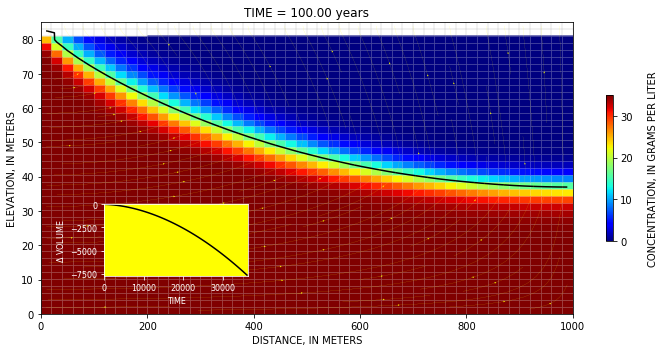

In [117]:
kper = -1
sl = get_sealevel(times[kper], sl_start, slr_rate)
make_figure(gwf, head[kper], conc[kper], spdis[kper], 
            sl, times[kper], top0, 
            ax2dict={'xdata': lensvoltsdiff[:kper, 0], 
                     'ydata': lensvoltsdiff[:kper, 1],
                     'xlabel': 'TIME',
                     'ylabel': '$\Delta$ VOLUME',
                     'xlim': (0, lensvolts[:, 0].max()),
                     'ylim': (lensvoltsdiff[:, 1].min(), lensvoltsdiff[:, 1].max())},
            streamplot=True)

In [118]:
make_png = True
if make_png:

    pngdir = os.path.join(ws, 'png')
    if os.path.isdir(pngdir):
        shutil.rmtree(pngdir)
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    kperlist = range(0, conc.shape[0])
    for ifig, kper in enumerate(kperlist):
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(pngdir, fname)
        print('writing {}'.format(fname))

        sl = get_sealevel(times[kper], sl_start, slr_rate)
        ax2dict = {'xdata': lensvoltsdiff[:kper, 0], 
                   'ydata': lensvoltsdiff[:kper, 1],
                   'xlabel': 'TIME',
                   'ylabel': '$\Delta$ VOLUME',
                   'xlim': (0, lensvolts[:, 0].max()),
                   'ylim': (lensvoltsdiff[:, 1].min(), lensvoltsdiff[:, 1].max())}
        make_figure(gwf, head[kper], conc[kper], spdis[kper], 
                    sl, times[kper], top0, 
                    ax2dict=ax2dict, streamplot=True, figname=fname)
        
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws, 'movie.mp4')
    make_movie(figfile, anmfile)

writing temp/pxx_gwt_slr-island/png/img0.png
writing temp/pxx_gwt_slr-island/png/img1.png
writing temp/pxx_gwt_slr-island/png/img2.png
writing temp/pxx_gwt_slr-island/png/img3.png
writing temp/pxx_gwt_slr-island/png/img4.png
writing temp/pxx_gwt_slr-island/png/img5.png
writing temp/pxx_gwt_slr-island/png/img6.png
writing temp/pxx_gwt_slr-island/png/img7.png
writing temp/pxx_gwt_slr-island/png/img8.png
writing temp/pxx_gwt_slr-island/png/img9.png
writing temp/pxx_gwt_slr-island/png/img10.png
writing temp/pxx_gwt_slr-island/png/img11.png
writing temp/pxx_gwt_slr-island/png/img12.png
writing temp/pxx_gwt_slr-island/png/img13.png
writing temp/pxx_gwt_slr-island/png/img14.png
writing temp/pxx_gwt_slr-island/png/img15.png
writing temp/pxx_gwt_slr-island/png/img16.png
writing temp/pxx_gwt_slr-island/png/img17.png
writing temp/pxx_gwt_slr-island/png/img18.png
writing temp/pxx_gwt_slr-island/png/img19.png
writing temp/pxx_gwt_slr-island/png/img20.png
writing temp/pxx_gwt_slr-island/png/img21.pn